In [152]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go 
import sys
# Adjust the path below to the path of your `module_directory`
sys.path.append('../thesis-2p-behavior-align/')
# Now you can import your module or function
import imaging_behavior_functions
import odor_behavioral_analysis
import scipy.cluster.hierarchy as sch
import glob
from scipy.stats import zscore
from scipy.stats import sem
import mat73
from rastermap import Rastermap, utils
from matplotlib import patches
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import SplineTransformer

In [135]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/stacks/"
example_path_data = base_path+"20240314-4_MB042B_TOM20GCAMP7f_odor/data/"
example_path_results = base_path+"20240314-4_MB042B_TOM20GCAMP7f_odor/results/"
trial_num = 3
odor_threshold = 5
time_interval_threshold = 16  # Assuming time is in seconds or an equivalent unit
k = 8
window_size = 30

is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions.load_intermediate_mat(example_path_data,trial_num)
behav_df = imaging_behavior_functions.make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor,trial_num,ball_d = 9)
xPos, yPos = imaging_behavior_functions.reconstruct_path(behav_df, ball_d = 9)
roi_names, hdeltab_index, epg_index, hdeltab_sequence, epg_sequence = imaging_behavior_functions.get_roi_seq(roi_df)
dff_all_rois, dff_time = imaging_behavior_functions.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions.make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, hdeltab_sequence, epg_sequence)
behav_df, padded_result_df, smoothed_df = odor_behavioral_analysis.analysis_dfs(behav_df, time_interval_threshold, k, window_size)
combined_df = imaging_behavior_functions.combine_df(behav_df, neural_df)
smoothed_df["translationalV_smoothed"] = np.sqrt(smoothed_df["fwV_smoothed"]**2+smoothed_df["sideV_smoothed"]**2)

In [136]:
selected_df = neural_df.drop(columns=['time'])
if 'odor' in behav_df.columns:
    odor_mask = behav_df['odor'] > 5

In [137]:
behav_df

time       fwV      sideV      yawV   heading   abssideV  \
0        0.000000  0.000000   0.000000  0.000000  1.529641   0.000000   
1        0.017168  3.149537  -0.908949  0.056287  1.530599   0.908949   
2        0.034337  4.313528  -1.091269  0.192863  1.528607   1.091269   
3        0.051505  4.922342  -0.712326  0.418163  1.530088   0.712326   
4        0.068674  5.424273   0.070363  0.621296  1.535090   0.070363   
...           ...       ...        ...       ...       ...        ...   
35526  609.927154  2.609966 -15.510520  1.239182  1.648241  15.510520   
35527  609.944323  3.601212 -19.511906  1.935824  1.655100  19.511906   
35528  609.961491  3.881801 -20.505185  2.498353  1.666405  20.505185   
35529  609.978660  3.365345 -18.358764  2.749837  1.684610  18.358764   
35530  609.995828  2.353569 -14.145338  2.520288  1.711484  14.145338   

        absyawV  net_motion  net_motion_state  heading_adj      odor  \
0      0.000000    0.000000                 0     1.529641 -0.000000   
1      0.056287    4.114773                 1     1.530599 -0.000000   
2      0.192863    5.597659                 1     1.528607 -0.000000   
3      0.418163    6.052831                 1     1.530088 -0.000000   
4      0.621296    6.115931                 1     1.535090 -0.000000   
...         ...         ...               ...          ...       ...   
35526  1.239182   19.359668                 1    -4.634944 -0.000000   
35527  1.935824   25.048942                 1    -4.628085 -0.000000   
35528  2.498353   26.885339                 1    -4.616780 -0.000000   
35529  2.749837   24.473946                 1    -4.598575 -0.000000   
35530  2.520288   19.019195                 1    -4.571701 -0.012211   

             xPos         yPos  cluster_label_temporal  \
0        0.000000     0.000000                       0   
1       -0.000816     0.053207                       0   
2       -0.001932     0.126222                       0   
3       -0.002573     0.210052                       0   
4       -0.001998     0.303244                       0   
...           ...          ...                     ...   
35526 -144.001121  1563.409648                       0   
35527 -144.014170  1563.454860                       0   
35528 -144.027118  1563.504179                       0   
35529 -144.038196  1563.546672                       0   
35530 -144.038196  1563.546672                       0   

       soft_cluster_label_temporal  cluster_label_spatial  
0                                0                      0  
1                                0                      0  
2                                0                      0  
3                                0                      0  
4                                0                      0  
...                            ...                    ...  
35526                            8                      0  
35527                            8                      0  
35528                            8                      0  
35529                            8                      0  
35530                            8                      0  

[35531 rows x 16 columns]

In [124]:
base_dir = '//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/stacks/20240314-4_MB042B_TOM20GCAMP7f_odor/E_05_Iter_10080_t3/suite2p/plane0'
F = np.load(base_dir+'/F.npy', allow_pickle=True)
Fneu = np.load(base_dir+'/Fneu.npy', allow_pickle=True)
spks = np.load(base_dir+'/spks.npy', allow_pickle=True)
stat = np.load(base_dir+'/stat.npy', allow_pickle=True)
ops =  np.load(base_dir+'/ops.npy', allow_pickle=True)
ops = ops.item()
iscell = np.load(base_dir+'/iscell.npy', allow_pickle=True)
x_pos = np.array([stat[i]['med'][0] for i in range(len(stat))])
x_pos_cell = x_pos[(iscell[:,0]==1)]
y_pos = np.array([stat[i]['med'][1] for i in range(len(stat))])
y_pos_cell = y_pos[(iscell[:,0]==1)]

In [125]:
F_cell = F[(iscell[:,0]==1),:]
spks_cell = spks[(iscell[:,0]==1),:]
Fneu_cell = Fneu[(iscell[:,0]==1),:]
stat_cell = stat[(iscell[:,0]==1)]
def dfoverf(F):
    # Determine F_0 using the 5th percentile of the fluorescence data
    F_0 = np.percentile(F, 5, axis=1)

    # Calculate ΔF/F
    deltaF_over_F = (F - F_0[:, np.newaxis]) / F_0[:, np.newaxis]
    return deltaF_over_F
dF_cell = dfoverf(F_cell)

### feature embedding

In [126]:
# load appropriate activity 
activity_mode = 0
if activity_mode == 0:
    fl_cell = F_cell
elif activity_mode == 1:
    fl_cell = Fneu_cell
elif activity_mode == 2:
    fl_cell = F_cell - 0.7 * Fneu_cell
else:
    fl_cell = dF_cell
fl_cell = zscore(fl_cell, axis=1)
fl_cell_norm = np.maximum(-4, np.minimum(8, fl_cell)) + 4
fl_cell_norm /= 12

In [127]:
model = Rastermap(n_clusters=10, # number of clusters to compute
                  n_PCs=160, # number of PCs to use
                  locality=0.75, # locality in sorting to find sequences (this is a value from 0-1)
                  time_lag_window=5, # use future timepoints to compute correlation
                  grid_upsample=10, # default value, 10 is good for large recordings
                  ).fit(fl_cell_norm)
y = model.embedding # neurons x 1
isort = model.isort

normalizing data across axis=1
projecting out mean along axis=0
data normalized, 0.46sec
sorting activity: 1070 valid samples by 35531 timepoints
n_PCs = 160 computed, 4.00sec
9 clusters computed, time 4.12sec
clusters sorted, time 4.16sec
clusters upsampled, time 4.18sec
rastermap complete, time 4.21sec


In [128]:
n_neurons, n_time = fl_cell.shape
nbin = 1 # number of neurons to bin over
ndiv = (n_neurons//nbin) * nbin
# group sorted matrix into rows of length nbin
sn = fl_cell[isort][:ndiv].reshape(ndiv//nbin, nbin, -1)
# take mean over neurons in a bin
sn = sn.mean(axis=1)

(-0.5, 0.5, 1069.5, -0.5)

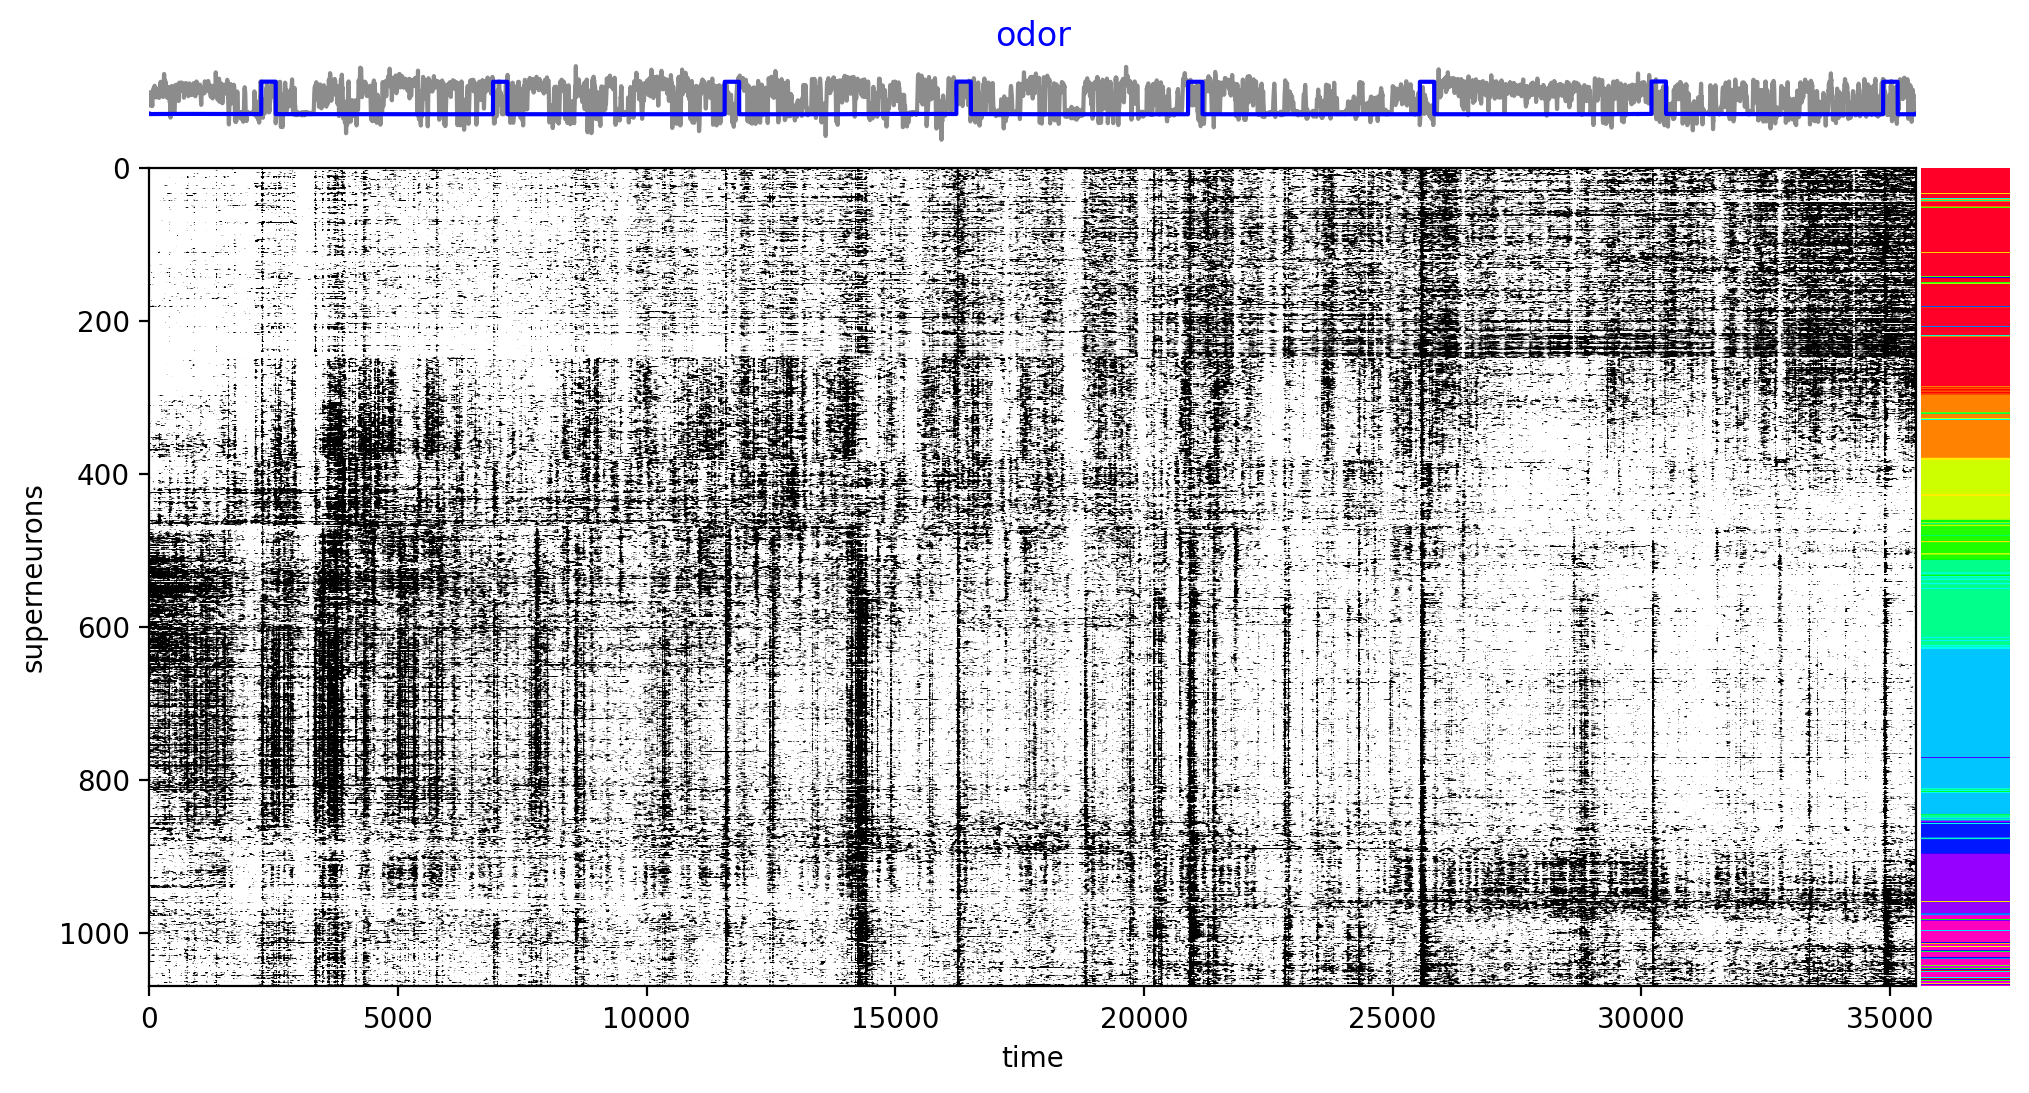

In [138]:
# timepoints to visualize
xmin = 0
xmax = xmin + len(behav_df)

# make figure with grid for easy plotting
fig = plt.figure(figsize=(12,6), dpi=200)
grid = plt.GridSpec(9, 20, figure=fig, wspace = 0.05, hspace = 0.3)

# colors for the behaviors
kp_colors = np.array([[0.55,0.55,0.55], [0.,0.,1],
                      [0.8,0,0], [1.,0.4,0.2],
                      [0,0.6,0.4], [0.2,1,0.5],
                      ])

# plot running speed
ax = plt.subplot(grid[0, :-1])
ax.plot(smoothed_df.fwV_smoothed[xmin:xmax], color=kp_colors[0])
ax.set_xlim([0, xmax-xmin])
ax.axis("off")
ax.set_title("forward speed", color=kp_colors[0])

# plot behavior
ax = plt.subplot(grid[0, :-1])
ax.plot(np.array(behav_df.odor[xmin:xmax]), color=kp_colors[1])
ax.set_xlim([0, xmax-xmin])
ax.axis("off")
ax.set_title("odor", color=kp_colors[1])


# plot superneuron activity
ax = plt.subplot(grid[1:, :-1])
ax.imshow(sn[:, xmin:xmax], cmap="gray_r", vmin=0, vmax=0.8, aspect="auto")
ax.set_xlabel("time")
ax.set_ylabel("superneurons")

ax = plt.subplot(grid[1:, -1])
ax.imshow(model.embedding_clust[isort][:,np.newaxis], cmap="gist_rainbow", aspect="auto")
ax.axis("off")


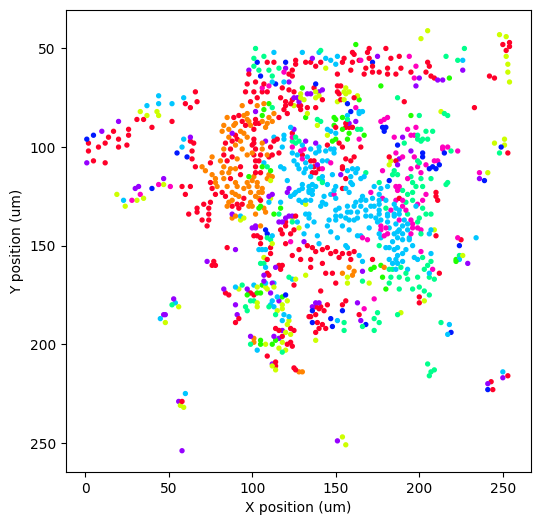

In [130]:
# POSITIONS OF ALL NEURONS
plt.figure(figsize=(6,6))
plt.scatter(y_pos_cell, x_pos_cell, s = 8, c=model.embedding_clust, cmap="gist_rainbow")
plt.xlabel('X position (um)')
plt.ylabel('Y position (um)')
plt.gca().invert_yaxis()

In [131]:
unique_val, unqiue_counts = np.unique(model.embedding_clust,return_counts=True)
print(unqiue_counts)

[292  91  88  43 120 233  39  86  78]


C:\Users\wilson\AppData\Local\Temp\ipykernel_10384\645084260.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_rainbow')


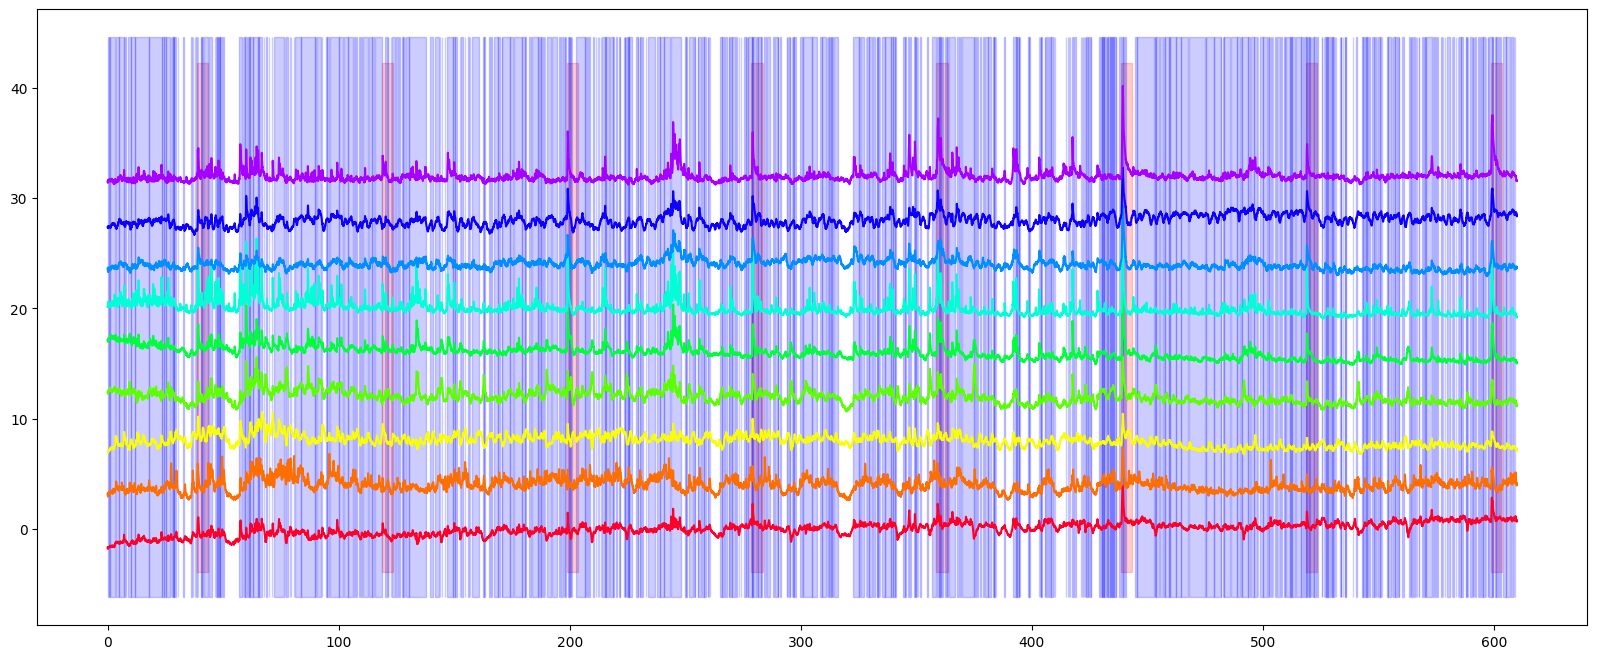

In [139]:
x_bins = unique_val[unqiue_counts>30]
# Get the gist_rainbow colormap
cmap = cm.get_cmap('gist_rainbow')
clus_mean = []
fig, ax = plt.subplots(figsize=(20,8))
y_offset = 4
for clus_index in x_bins:
    clus_ts = fl_cell[model.embedding_clust == clus_index]
    color = cmap(clus_index / len(unique_val))
    ax.plot(behav_df.time,np.mean(clus_ts,axis=0)+ (clus_index * y_offset),color=color)
    clus_mean.append(np.mean(clus_ts,axis=0))
ax.fill_between(behav_df.time, ax.get_ylim()[0], ax.get_ylim()[1], where=odor_mask, color='red', alpha=0.2)
motion_mask = (behav_df.fwV >= 4)
#heading_mask = 
ax.fill_between(behav_df.time, ax.get_ylim()[0], ax.get_ylim()[1], where=motion_mask, color='blue', alpha=0.2)

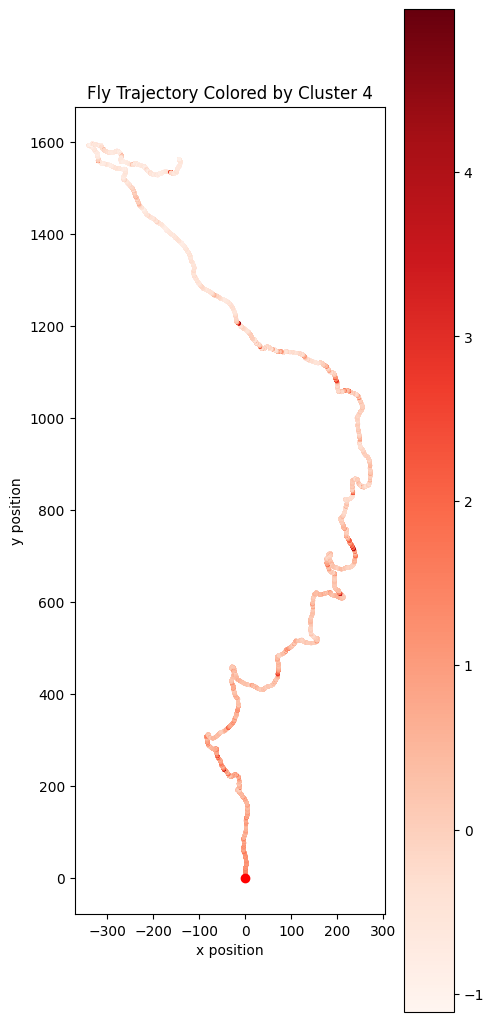

In [140]:
# plot on trajectory
def plot_fly_traj(xPos, yPos, color_var,color_var_name):
    x_range = max(xPos) - min(xPos)
    y_range = max(yPos) - min(yPos)
    aspect_ratio = y_range / x_range

    # Set figure dimensions based on data range while keeping unit scale the same
    fig_width = 5  # Width of figure in inches
    fig_height = fig_width * aspect_ratio  # Height is scaled according to the aspect ratio of the data

    plt.figure(figsize=(fig_width, fig_height))

    plt.scatter(xPos, yPos, s=3, c= color_var,cmap = 'Reds')
    plt.colorbar()
    plt.scatter(0, 0, color='red')  # Mark the origin

    # Enforce equal aspect ratio so that one unit in x is the same as one unit in y
    plt.gca().set_aspect('equal', adjustable='box')

    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.title('Fly Trajectory Colored by '+color_var_name)

plot_fly_traj(xPos, yPos, clus_mean[4], 'Cluster 4')

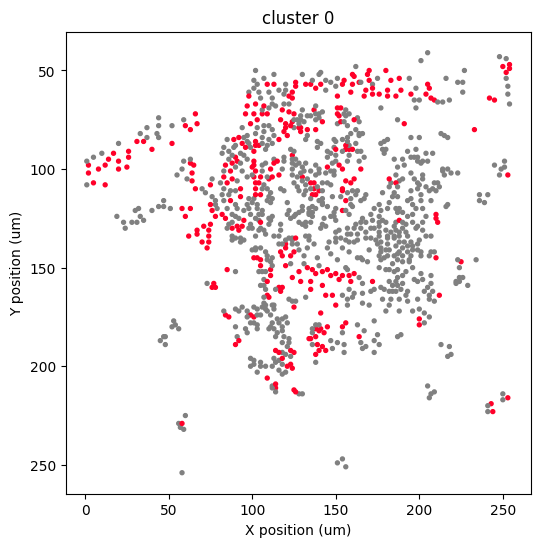

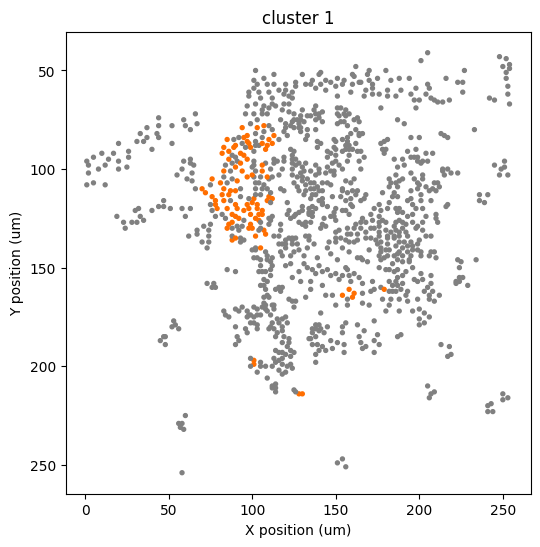

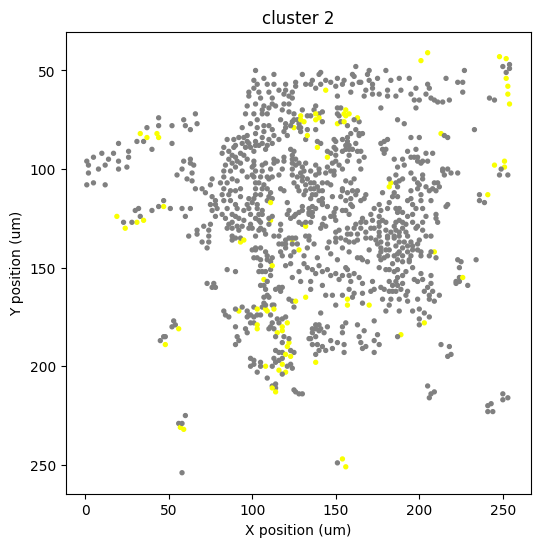

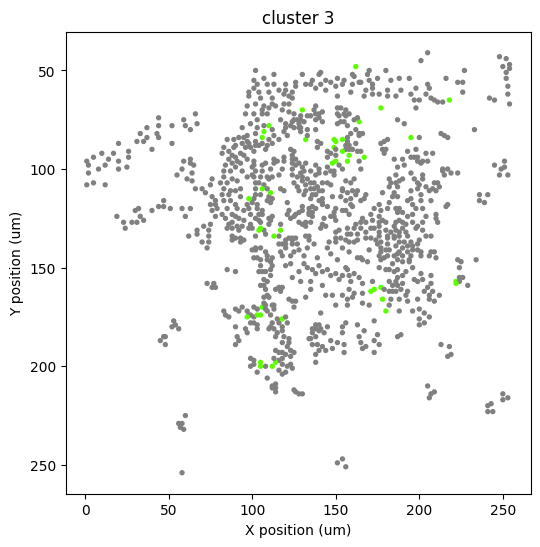

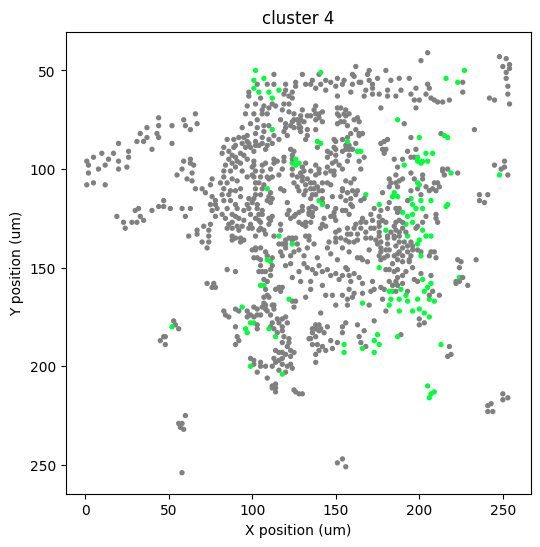

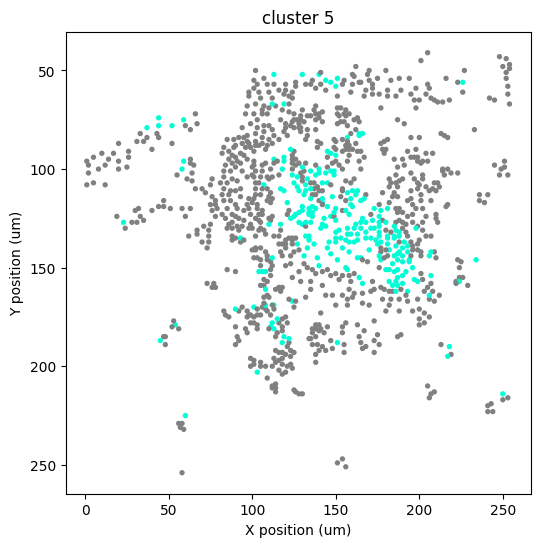

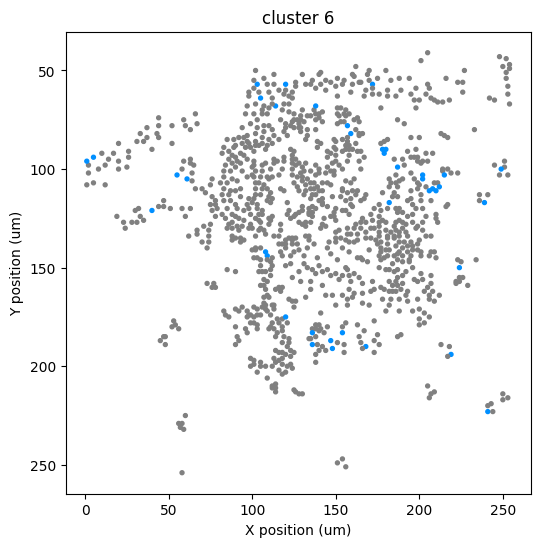

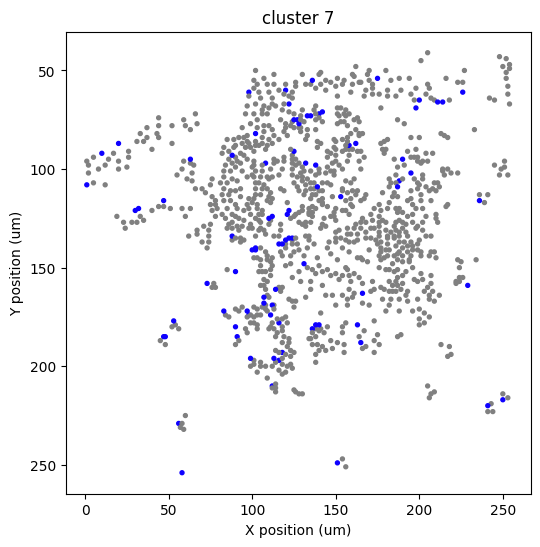

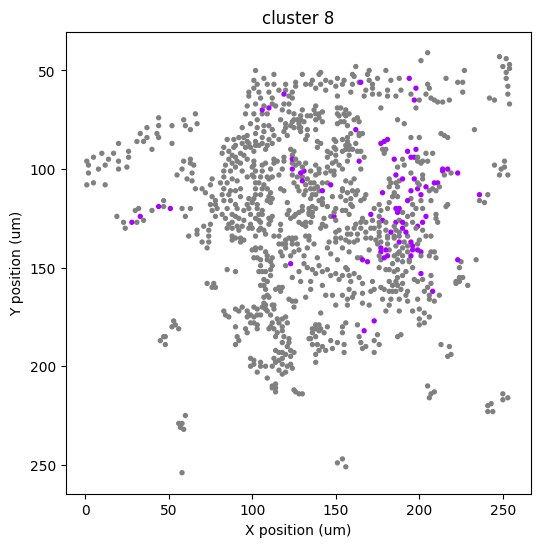

In [141]:
# Assuming cell_classes contains the class for each cell and class_of_interest is the one you want to highlight
def highlight_class(bin_index, mapped_embeddings,highlight_color):
    class_of_interest = bin_index  # Replace 'YourClassHere' with the actual class of interest
    #highlight_color = 'red'  # Replace 'YourHighlightColorHere' with the color you want for the class of interest, e.g., 'red'

    # Correct Approach: Initializing a color array
    colors = np.array(['gray'] * len(mapped_embeddings), dtype=object)  # Initializing with 'gray'

    # Apply highlight_color
    indices_of_interest = np.where(mapped_embeddings == class_of_interest)[0]
    for index in indices_of_interest:
        colors[index] = highlight_color

    # Now plot with the modified colors
    plt.figure(figsize=(6,6))
    plt.scatter(y_pos_cell, x_pos_cell, s=8, c=colors)  # Note: cmap here may not affect the colors since we're manually setting them
    plt.xlabel('X position (um)')
    plt.ylabel('Y position (um)')
    plt.gca().invert_yaxis()
    plt.title(f'cluster {bin_index}')
    #plt.axis("square")
    plt.show()

for i in range(len(unique_val)):
    highlight_class(i, model.embedding_clust,cmap(i / len(unique_val)))

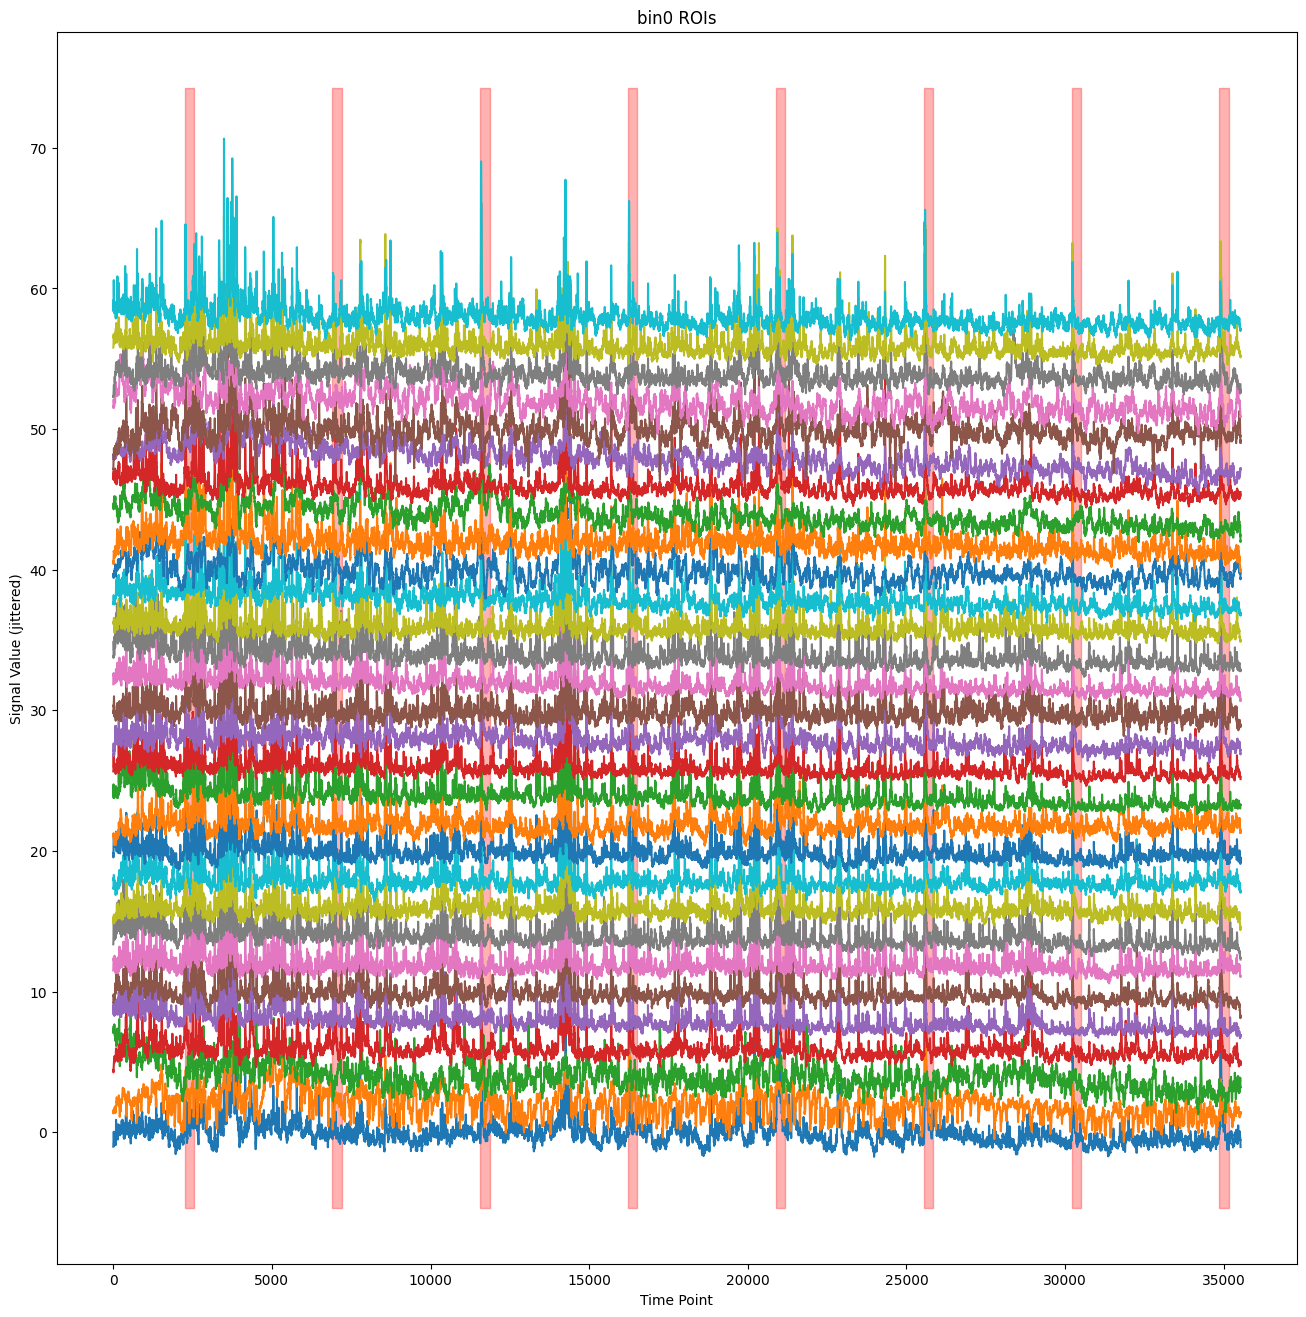

In [145]:
fig,ax = plt.subplots(figsize=(16, 16))
bin_index = 5
# Plot each signal with a jitter on the y-axis
y_offset = 2  # Adjust the offset value as needed
sn_binx = fl_cell[model.embedding_clust == bin_index]
for i in range(30):
    ax.plot(sn_binx[i,:] + (i * y_offset), label=f'Signal {i+1}')
ax.fill_between(behav_df.index, ax.get_ylim()[0], ax.get_ylim()[1], where=odor_mask, color='red', alpha=0.3)
    
# Add labels and title
plt.xlabel('Time Point')
plt.ylabel('Signal Value (jittered)')
plt.title('bin0 ROIs')

# Optionally, add a legend
#plt.legend()

# Show the plot
plt.show()

In [146]:
# plot around odor delivery
def find_odor_start_end(behav_df):
    odor_on = behav_df[behav_df.odor > 5].index
    odor_start = [odor_on[0]]
    odor_end = []
    for i in range(len(odor_on)-1):
        if odor_on[i+1] - odor_on[i]>5:
            odor_start.append(odor_on[i+1])
            odor_end.append(odor_on[i])
    if odor_on[-1] != len(behav_df)-1:
        odor_end.append(odor_on[-1])
    return odor_start[0:len(odor_end)], odor_end
odor_start, odor_end = find_odor_start_end(behav_df)


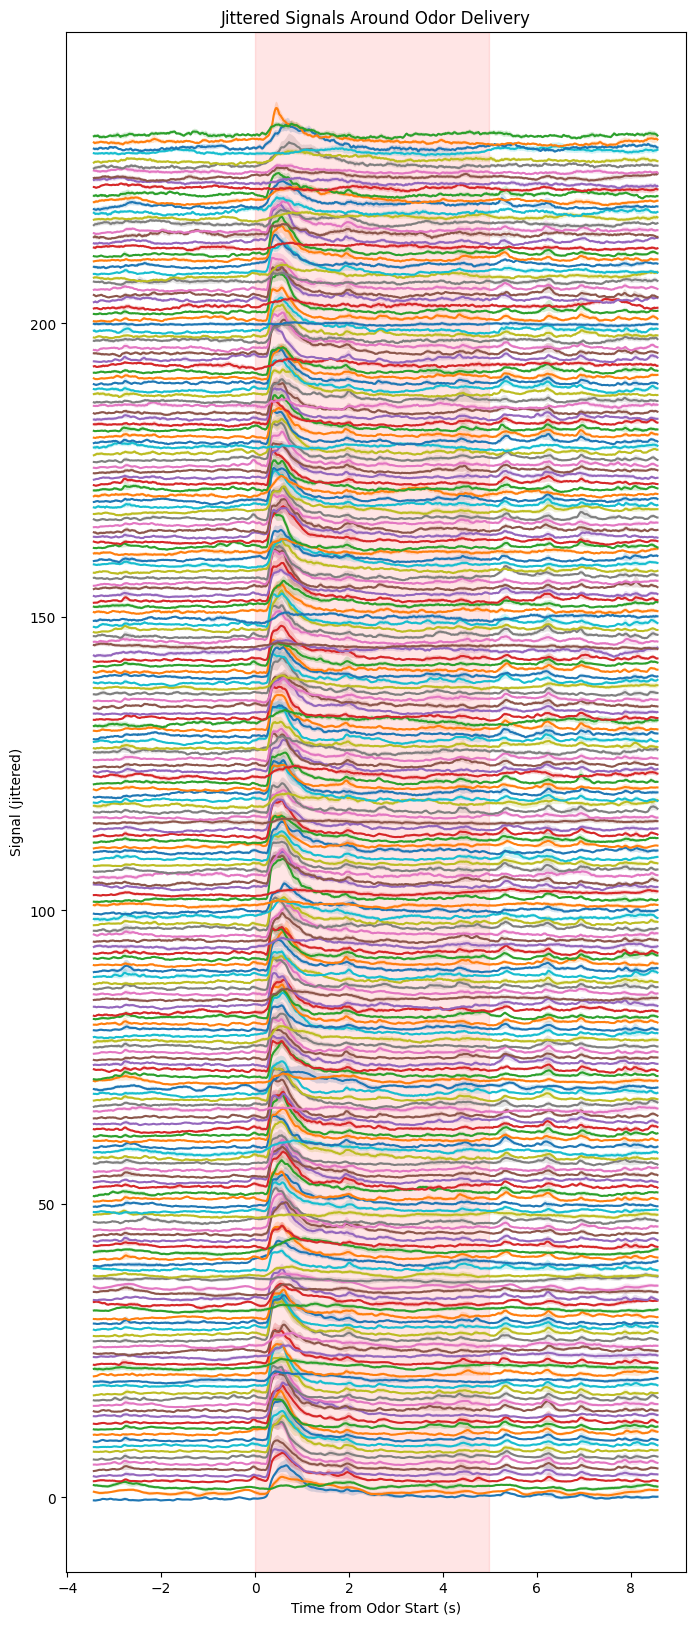

In [147]:
def plot_jittered_signals_around_odor(sn_binx, behav_df, y_jitter):
    """
    Plots all rows of sn_binx in a jittered manner on the y-axis around the odor delivery windows.

    Parameters:
    - sn_binx: 2D numpy array with dimensions (rows, time) representing signals to plot.
    - behav_df: DataFrame containing behavioral data, including time, odor_start, and odor_end.
    - y_jitter: float, the y-offset to apply between each row for clarity.
    """
    fig, ax = plt.subplots(figsize=[8,20])
    odor_start, odor_end = find_odor_start_end(behav_df)
    
    # Loop through each row in sn_binx
    for row_idx in range(sn_binx.shape[0]):
        odor_all = []
        for i in range(len(odor_start)-1):
            ind1 = odor_start[i] - 200
            ind2 = odor_start[i] + 500
            odor_all.append(sn_binx[row_idx, ind1:ind2])
        
        # Calculate mean and standard deviation for odor_all segments
        odor_mean = np.mean(np.array(odor_all), axis=0)
        odor_std = np.std(np.array(odor_all), axis=0) / np.sqrt(len(odor_all))  # Standard Error of the Mean (SEM)
        
        # Plot the mean signal for each row with y-offset
        ax.plot(behav_df.time[ind1:ind2] - behav_df.time[odor_start[i]], odor_mean + (row_idx * y_jitter), label=f'Row {row_idx}')
        
        # Optional: Add fill_between for SEM or STD
        ax.fill_between(behav_df.time[ind1:ind2] - behav_df.time[odor_start[i]],
                         odor_mean - odor_std + (row_idx * y_jitter),
                         odor_mean + odor_std + (row_idx * y_jitter), alpha=0.2)

    # Highlight the odor delivery window
    ax.axvspan(0, behav_df.time[odor_end[0]] - behav_df.time[odor_start[0]], color='red', alpha=0.1)
    
    plt.xlabel('Time from Odor Start (s)')
    plt.ylabel('Signal (jittered)')
    plt.title('Jittered Signals Around Odor Delivery')
    #plt.legend()
plot_jittered_signals_around_odor(sn_binx, behav_df, 1)

In [148]:
# Bin the behavioral variable
#num_bins = 10  # Number of bins for the behavioral variable
def tuning_curve_pop(num_bins, behavior_variable, neural_activity):
    bins = np.linspace(np.min(behavior_variable), np.max(behavior_variable), num_bins+1)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Initialize an array to hold the mean activity for each neuron across bins
    mean_activity_matrix = np.zeros((neural_activity.shape[0], num_bins))

    # Calculate the mean activity for each neuron in each bin
    for i in range(neural_activity.shape[0]):  # Loop over neurons
        for j in range(num_bins):  # Loop over bins
            # Find indices of behavior_variable that fall into the current bin
            indices = np.where((behavior_variable >= bins[j]) & (behavior_variable < bins[j+1]))[0]
            # Calculate the mean activity of the current neuron for these indices
            if len(indices) > 0:
                mean_activity_matrix[i, j] = np.mean(neural_activity[i, indices])
            else:
                mean_activity_matrix[i, j] = np.nan  # Use NaN for bins with no data points

    # Fixed figure width
    fig_width = 10  # Fixed width for all figures
    
    # Adjustable figure height based on the matrix height, smaller relative to width
    height_scale_factor = 0.02  # Smaller scale factor for height
    min_height = 2  # Minimum height to ensure figure is not too small
    fig_height = max(min_height, neural_activity.shape[0] * height_scale_factor)

    # Plotting the heatmap
    plt.figure(figsize=(fig_width, fig_height))
    plt.imshow(mean_activity_matrix, aspect='auto', cmap='viridis',
            extent=[bins[0], bins[-1], 0, neural_activity.shape[0]])
    plt.colorbar(label='Average Neural Activity')
    plt.xlabel(behavior_variable.name)
    plt.ylabel('Neurons')
    plt.title('Neural Activity Tuning Curves Heatmap')
    plt.show()
#tuning_curve_pop(num_bins, behavior_variable, neural_activity)

In [149]:

def filter_based_on_histogram(behavior_variable, min_freq_threshold):
    """
    Filters the behavioral variable data to remove points distant from the main mode,
    isolated by at least two consecutive bins with very low frequency. Automatically adjusts
    bins based on the Freedman-Diaconis rule.
    
    Parameters:
    - behavior_variable: Pandas Series, the behavioral variable data.
    - min_freq_threshold: The minimum frequency (as a proportion of total) to consider a bin as non-negligible.
    
    Returns:
    - Pandas Series, filtered behavioral variable data.
    """
    # Calculate bin width using the Freedman-Diaconis rule
    #IQR = np.subtract(*np.percentile(behavior_variable, [75, 25]))
    #n = len(behavior_variable)
    bin_width = 1
    range_ = np.max(behavior_variable) - np.min(behavior_variable)
    bins = int(np.round(range_ / bin_width))
    print(bins)
    # Compute the histogram with the calculated number of bins
    counts, bin_edges = np.histogram(behavior_variable, bins=bins)
    #total_points = n
    #freqs = counts / total_points  # Frequency of each bin
    
    # Identify bins below the frequency threshold
    low_freq_bins_mask = counts < min_freq_threshold
    
    # Find indices where two consecutive bins are below the threshold
    two_consecutive_low_bins = np.where(np.convolve(low_freq_bins_mask, [1,1], mode='valid') == 2)[0]
    
    if two_consecutive_low_bins.size == 0:
        return behavior_variable  # No such consecutive low bins, return original series
    
    # Determine cutoffs
    mode_bin_index = np.argmax(counts)
    lower_cutoff_bins = two_consecutive_low_bins[two_consecutive_low_bins < mode_bin_index]
    upper_cutoff_bins = two_consecutive_low_bins[two_consecutive_low_bins > mode_bin_index]
    lower_cutoff = bin_edges[0] if lower_cutoff_bins.size == 0 else bin_edges[lower_cutoff_bins.max() + 2]  # +2 to include the low bin
    upper_cutoff = bin_edges[-1] if upper_cutoff_bins.size == 0 else bin_edges[upper_cutoff_bins.min()]
    
    # Filter the behavioral variable
    filtered_variable = behavior_variable[(behavior_variable >= lower_cutoff) & (behavior_variable <= upper_cutoff)]
    
    return filtered_variable
# Example usage:

In [150]:

def tuning_curve_1d(behavior_variable, neural_activity,neurons_to_plot,num_bins):
# Bin the behavioral variable
    bins = np.linspace(np.min(behavior_variable), np.max(behavior_variable), num_bins+1)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Initialize a plot
    plt.figure(figsize=(10, 6))

    # Plot tuning curves with SEM for selected neurons
    for neuron_index in neurons_to_plot:
        # Bin neural activity based on the behavioral variable
        binned_activity = np.empty(num_bins)
        binned_sem = np.empty(num_bins)  # Array to store the SEM values for each bin
        
        for i in range(num_bins):
            # Find indices of behavior_variable that fall into the current bin
            indices = np.where((behavior_variable >= bins[i]) & (behavior_variable < bins[i+1]))[0]
            # Calculate the mean activity of the current neuron for these indices
            bin_data = neural_activity[neuron_index, indices]
            binned_activity[i] = np.mean(bin_data)
            # Calculate SEM for the current bin
            binned_sem[i] = sem(bin_data)
        
        # Plot mean activity
        plt.plot(bin_centers, binned_activity, label=f'Neuron {neuron_index}')
        # Add SEM shading
        plt.fill_between(bin_centers, binned_activity - binned_sem, binned_activity + binned_sem, alpha=0.3)

    # Beautifying the plot
    plt.xlabel(behavior_variable.name)
    plt.ylabel('Average Neural Activity')
    plt.legend()
    plt.title('Neural Activity Tuning Curves with SEM')
    plt.show()
#tuning_curve_1d(behavior_variable, neural_activity,neurons_to_plot,num_bins)

27
252
56
6


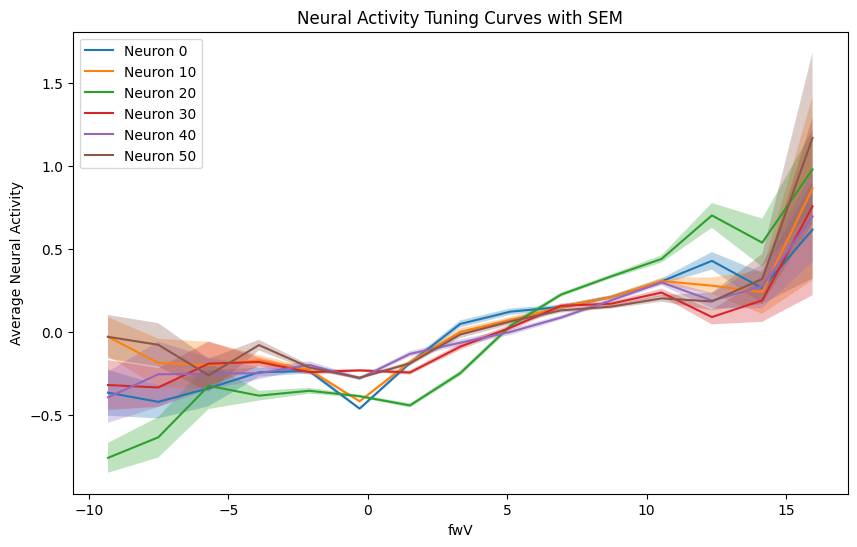

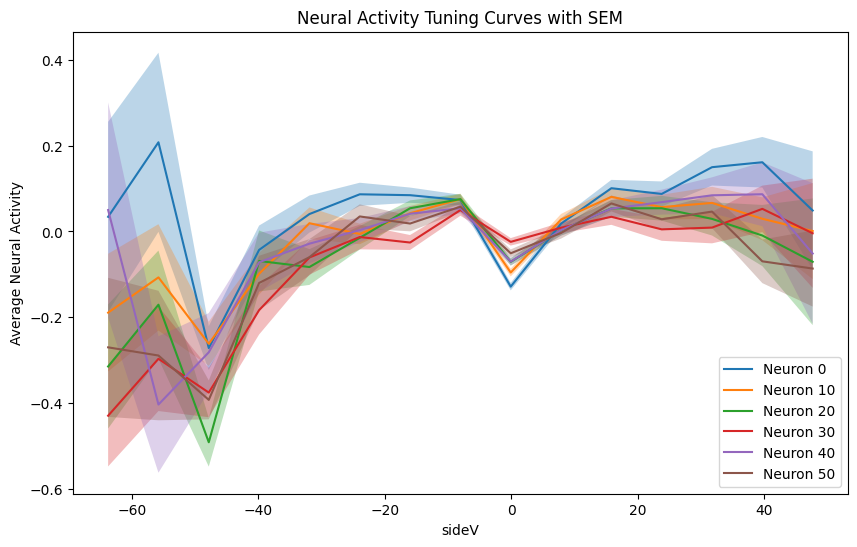

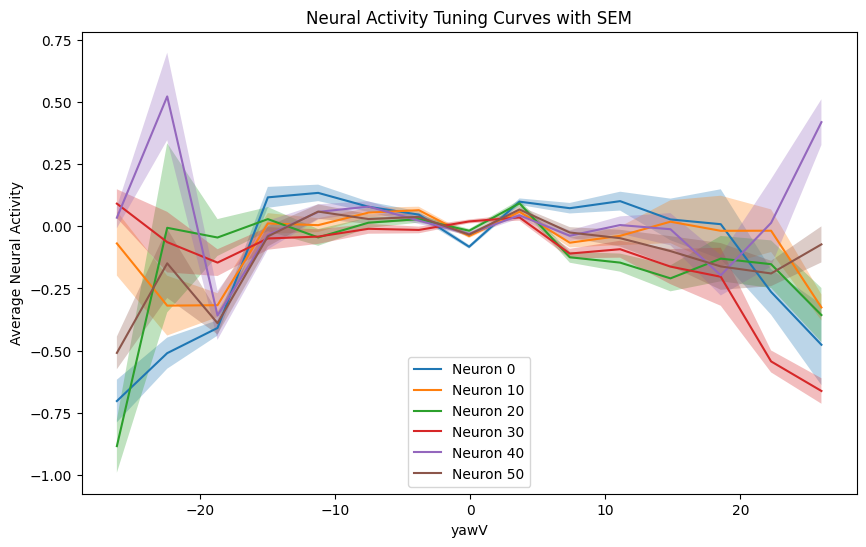

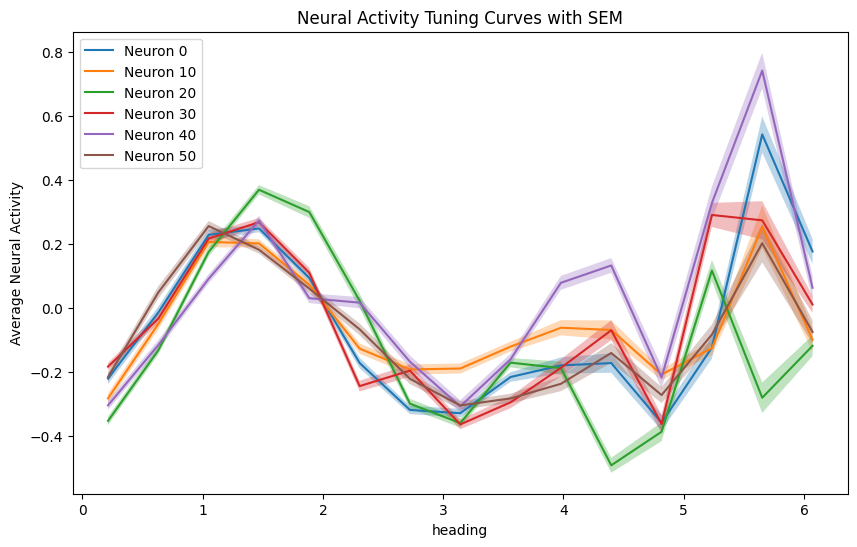

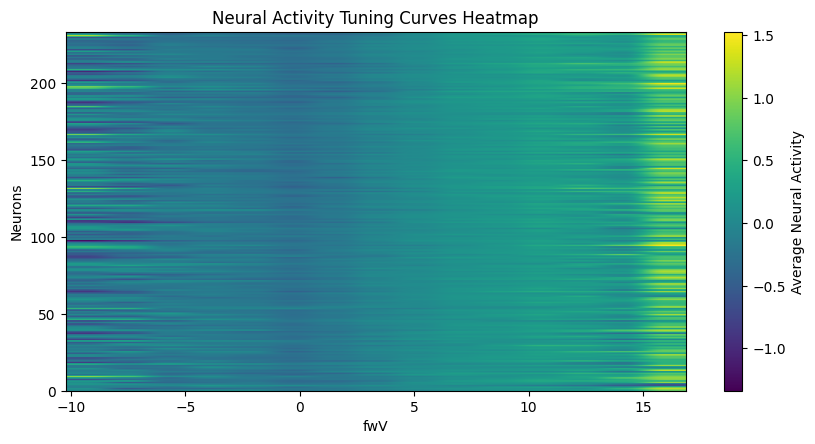

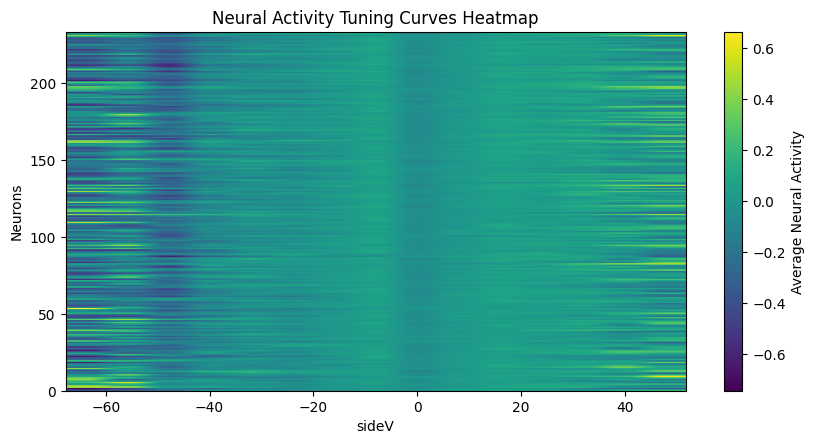

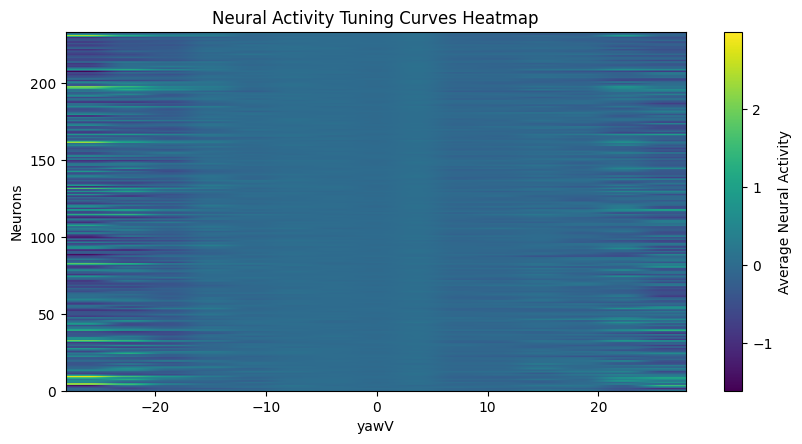

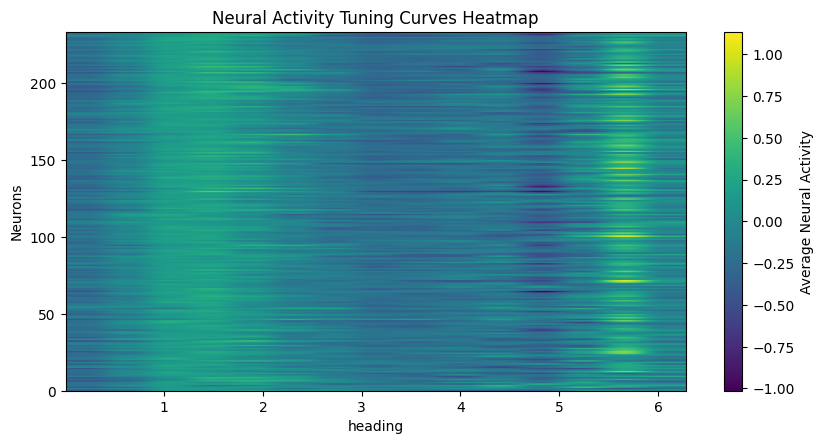

In [151]:
# Determine the number of rows and columns for the subplot grid
behavioral_variables = [behav_df.fwV, behav_df.sideV, behav_df.yawV, behav_df.heading]
filtered_behavior_variables = [filter_based_on_histogram(var, 0.5) for var in behavioral_variables]
neural_activity = sn_binx
num_bins = 15
neurons_to_plot = [0, 10, 20, 30, 40, 50]
num_behavioral_variables = len(filtered_behavior_variables)
for i, behavior_variable in enumerate(filtered_behavior_variables):
    tuning_curve_1d(behavior_variable, neural_activity,neurons_to_plot,num_bins)
# Loop through behavioral variables and plot
for i, behavior_variable in enumerate(filtered_behavior_variables):
    tuning_curve_pop(num_bins, behavior_variable, neural_activity)

### feature building

In [153]:
# heading
def circular_feature_preprocessing(x):
    # Assuming x is in radians and wraps around at 2*pi
    return np.column_stack((np.sin(x), np.cos(x)))
processed_heading = circular_feature_preprocessing(behav_df.heading)
spline = SplineTransformer(degree=2, n_knots=3)
transformed_heading = spline.fit_transform(processed_heading)
transformed_heading.shape

(35531, 8)

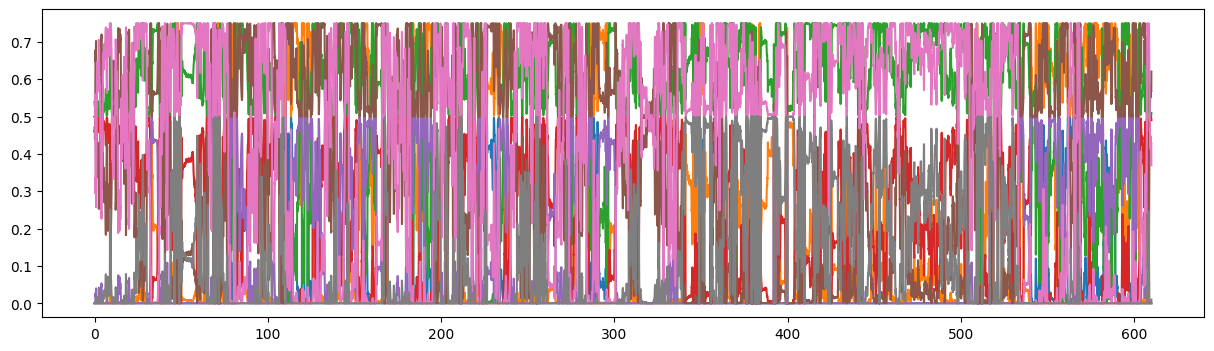

In [154]:
plt.figure(figsize=(15, 4))
for i in range(transformed_heading.shape[1]):
    plt.plot(behav_df.time, transformed_heading[:,i])

In [155]:
behav_df.head(10)

time       fwV     sideV      yawV   heading  abssideV   absyawV  \
0  0.000000  0.000000  0.000000  0.000000  1.529641  0.000000  0.000000   
1  0.017168  3.149537 -0.908949  0.056287  1.530599  0.908949  0.056287   
2  0.034337  4.313528 -1.091269  0.192863  1.528607  1.091269  0.192863   
3  0.051505  4.922342 -0.712326  0.418163  1.530088  0.712326  0.418163   
4  0.068674  5.424273  0.070363  0.621296  1.535090  0.070363  0.621296   
5  0.085842  5.704665  0.969238  0.643216  1.539579  0.969238  0.643216   
6  0.103011  5.547454  1.763901  0.365505  1.540569  1.763901  0.365505   
7  0.120179  5.118222  2.798633 -0.188818  1.543387  2.798633  0.188818   
8  0.137348  4.850258  5.432346 -0.941211  1.539664  5.432346  0.941211   
9  0.154516  5.220744  9.168209 -1.518238  1.527285  9.168209  1.518238   

   net_motion  net_motion_state  heading_adj      odor      xPos      yPos  \
0    0.000000                 0     1.529641 -0.000000  0.000000  0.000000   
1    4.114773                 1     1.530599 -0.000000 -0.000816  0.053207   
2    5.597659                 1     1.528607 -0.000000 -0.001932  0.126222   
3    6.052831                 1     1.530088 -0.000000 -0.002573  0.210052   
4    6.115931                 1     1.535090 -0.000000 -0.001998  0.303244   
5    7.317120                 1     1.539579 -0.000000 -0.000092  0.402094   
6    7.676859                 1     1.540569 -0.176493  0.002649  0.498993   
7    8.105674                 1     1.543387 -0.175170  0.006562  0.589489   
8   11.223815                 1     1.539664 -0.175229  0.012628  0.677883   
9   15.907191                 1     1.527285 -0.179488  0.021138  0.776278   

   cluster_label_temporal  soft_cluster_label_temporal  cluster_label_spatial  
0                       0                            0                      0  
1                       0                            0                      0  
2                       0                            0                      0  
3                       0                            0                      0  
4                       0                            0                      0  
5                       0                            0                      0  
6                       0                            0                      0  
7                       0                            0                      0  
8                       0                            0                      0  
9                       0                            0                      0

In [156]:
# velocities 

# Assuming df is your DataFrame with columns 'forward', 'side', 'yaw'

def create_shifted_features(df, shifts):
    """
    Create shifted features for each column in the DataFrame.
    
    Args:
    - df (pd.DataFrame): Original DataFrame with columns to be shifted.
    - shifts (list of int): List of integers representing the shifts (positive for forward, negative for backward).
    
    Returns:
    - pd.DataFrame: DataFrame with original and shifted columns.
    """
    feature_df = df.copy()
    for col in df.columns:
        for shift in shifts:
            if shift > 0:
                feature_df[f'{col}_shifted_back_{shift}'] = df[col].shift(-shift)  # Future values
            elif shift < 0:
                feature_df[f'{col}_shifted_forward_{-shift}'] = df[col].shift(-shift)  # Past values
            # If shift == 0, do nothing (keep original column)
    feature_df = feature_df.fillna(0)
    return feature_df

# Example usage
shifts = list(range(-10,11)) # Shifts of 2 and 1 step(s) back in time, and 1 and 2 step(s) forward in time
expanded_velocity_df = create_shifted_features(behav_df[['fwV','yawV']], shifts)

#print(expanded_velocity_df.head())


In [157]:
# odors 
def find_odor_start_end(behav_df):
    odor_on = behav_df[behav_df.odor > 5].index
    odor_start = [odor_on[0]]
    odor_end = []
    for i in range(len(odor_on)-1):
        if odor_on[i+1] - odor_on[i]>5:
            odor_start.append(odor_on[i+1])
            odor_end.append(odor_on[i])
    if odor_on[-1] != len(behav_df)-1:
        odor_end.append(odor_on[-1])
    return odor_start[0:len(odor_end)], odor_end
odor_start, odor_end = find_odor_start_end(behav_df)

In [158]:
odor_start_arr = np.zeros(len(behav_df))
odor_start_arr[odor_start] = 1
behav_df['odor_on'] = odor_start_arr
odor_end_arr = np.zeros(len(behav_df))
odor_end_arr[odor_end] = 1
behav_df['odor_end'] = odor_end_arr

In [159]:
# Assuming 'df' is your DataFrame and it contains a column 'odor' for odor stimuli

def shift_and_smooth_odor(column, shifts, kernel_size):
    """
    Shift the odor column forward in time and smooth it with a kernel.
    
    Args:
    - df (pd.DataFrame): DataFrame with the 'odor' column.
    - shifts (list of int): List of shift amounts (positive for forward in time).
    - kernel_size (int): Size of the kernel for convolution (number of points).
    
    Returns:
    - pd.DataFrame: DataFrame with shifted and smoothed odor columns.
    """
    # Create a raised cosine bump kernel
    x = np.linspace(-np.pi, np.pi, kernel_size)
    kernel = np.cos(x)**2
    kernel /= kernel.sum()  # Normalize the kernel
    
    # Copy the DataFrame to avoid modifying the original
    new_df = pd.DataFrame()
    
    for shift in shifts:
        shifted_odor = column.shift(-shift).fillna(0)
        # Convolve with the kernel and assign to a new column
        smoothed_odor = scipy.signal.convolve(shifted_odor, kernel, mode='same')
        new_df[f'odor_shifted_{shift}_smoothed'] = smoothed_odor
        
    return new_df

# Example usage
shifts = [1, 2, 3, 4]  # Shifts forward in time by 1, 2, 3, 4 time points
kernel_size = 10  # Size of the convolution kernel

expanded_odor_df = shift_and_smooth_odor(behav_df.odor_on, shifts, kernel_size)

# Display the first few rows of the new DataFrame
print(expanded_odor_df.head())


   odor_shifted_1_smoothed  odor_shifted_2_smoothed  odor_shifted_3_smoothed  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                      0.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   odor_shifted_4_smoothed  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  
